In [47]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [48]:
def load_dataframes(imputed_file_path, daily_file_path):
    imputed_df = pd.read_csv(imputed_file_path)
    daily_df = pd.read_csv(daily_file_path)
    return imputed_df, daily_df

def create_subdatasets_by_node_id(df: pd.DataFrame)-> dict:
    grouped_data = df.groupby('NodeID')
    subdatasets = {key: group for key, group in grouped_data}
    return subdatasets

def train_test_split(df, num_wells):
    random.seed(42)

    train_node_ids = random.sample(list(df['NodeID'].unique()), num_wells)
    train_data = df[df['NodeID'].isin(train_node_ids)]
    
    test_node_ids = list(set(df['NodeID'].unique()) - set(train_node_ids))
    test_data = df[df['NodeID'].isin(test_node_ids)]
    
    return train_data, test_data

def plot_roc_curve_and_confusion_matrix(y_true, y_pred, ax=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title('\nConfusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    axs[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('1-Specificity')
    axs[1].set_ylabel('Sensitivity')
    axs[1].set_title('\nReceiver Operating Characteristic (ROC) Curve')
    axs[1].legend(loc="lower right")
    plt.subplots_adjust(wspace=5) 
    plt.tight_layout()
    plt.show()
    return cm

def calculate_metrics_from_confusion_matrix(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
        'Score': [accuracy, precision, recall, f1]
    })

    return metrics_df

In [49]:
imputed_file_path = '..\\data\\interim\\imputed_data.csv'
daily_file_path = '..\\data\\interim\\daily_averaged_data.csv'
imputed_df, daily_df = load_dataframes(imputed_file_path, daily_file_path)

In [50]:
subdatasets = create_subdatasets_by_node_id(imputed_df)

In [36]:
for key, df in subdatasets.items():
    window_size = 5
    features = ["MotorCurrent", "Frequency", "PIP", "TubingPressure", "CasingPressure", "PIT", "MotorTemperature", "XVib"]
    rolling_stats_df = pd.DataFrame(index=df.index)
    for feature in features:
        rolling_mean = df[feature].rolling(window=window_size).mean()
        rolling_stats_df[f'{feature}_RollingMean'] = rolling_mean
        rolling_variance = df[feature].rolling(window=window_size).var()
        rolling_stats_df[f'{feature}_RollingVariance'] = rolling_variance
        rolling_max = df[feature].rolling(window=window_size).max()
        rolling_stats_df[f'{feature}_RollingMax'] = rolling_max
        rolling_min = df[feature].rolling(window=window_size).min()
        rolling_stats_df[f'{feature}_RollingMin'] = rolling_min
        
    df_with_rolling_stats = pd.concat([df, rolling_stats_df], axis=1)
    subdatasets[key] = df_with_rolling_stats

In [51]:
modified_datasets_dict = {}

for key, df in subdatasets.items():
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].shift(-120)  
    df_copy["Label"].fillna(1, inplace=True)
    modified_datasets_dict[key] = df_copy

In [52]:
merged_df = pd.concat(modified_datasets_dict.values(), ignore_index=True)
merged_df.head()

merged_df['Label'] = merged_df['Label'].astype(int)

In [53]:
merged_df.to_csv(r'..\data\interim\fet_eng_data.csv', index=False)

In [54]:
df_train, df_test = train_test_split(merged_df, 10)

df_train.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
0,0,2020-01-10 00:00:00,31.083333,58.916667,599.000000,211.0,118.000000,247.000000,277.333333,2.083333,0
1,0,2020-01-10 01:00:00,31.000000,59.000000,598.500000,204.0,118.000000,247.000000,277.416667,2.250000,0
2,0,2020-01-10 02:00:00,30.916667,59.000000,598.416667,197.0,118.000000,247.000000,277.416667,2.000000,0
3,0,2020-01-10 03:00:00,31.000000,58.909091,597.181818,197.0,119.272727,247.000000,277.181818,2.000000,0
4,0,2020-01-10 04:00:00,31.000000,59.454545,604.000000,197.0,132.000000,247.454545,278.181818,2.000000,0


In [55]:
X_train = df_train.drop(['Label', 'NodeID', 'Date'], axis = 1)
y_train = df_train['Label']
X_test = df_test.drop(['Label', 'NodeID', 'Date'], axis = 1)
y_test = df_test['Label']

In [56]:
X_train.head()

,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib
0,31.083333,58.916667,599.000000,211.0,118.000000,247.000000,277.333333,2.083333
1,31.000000,59.000000,598.500000,204.0,118.000000,247.000000,277.416667,2.250000
2,30.916667,59.000000,598.416667,197.0,118.000000,247.000000,277.416667,2.000000
3,31.000000,58.909091,597.181818,197.0,119.272727,247.000000,277.181818,2.000000
4,31.000000,59.454545,604.000000,197.0,132.000000,247.454545,278.181818,2.000000


In [57]:
X_train.shape

(21562, 8)

### $\textbf{Decision Tree}$

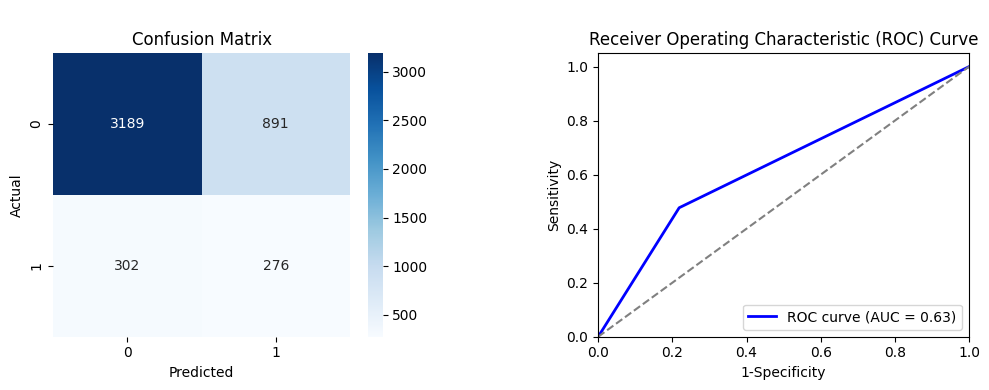

In [83]:
dt_model = DecisionTreeClassifier(random_state=42,
                                  max_depth=5,
                                  min_samples_split=4,
                                  min_samples_leaf=5,
                                  max_features=5,
                                  criterion='entropy')

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
cm = plot_roc_curve_and_confusion_matrix(y_test, y_pred_dt)

In [84]:
calculate_metrics_from_confusion_matrix(cm)

,Metric,Score
0,Accuracy,0.743881
1,Precision,0.236504
2,Recall,0.477509
3,F1-score,0.316332


### $\textbf{Random Forest}$

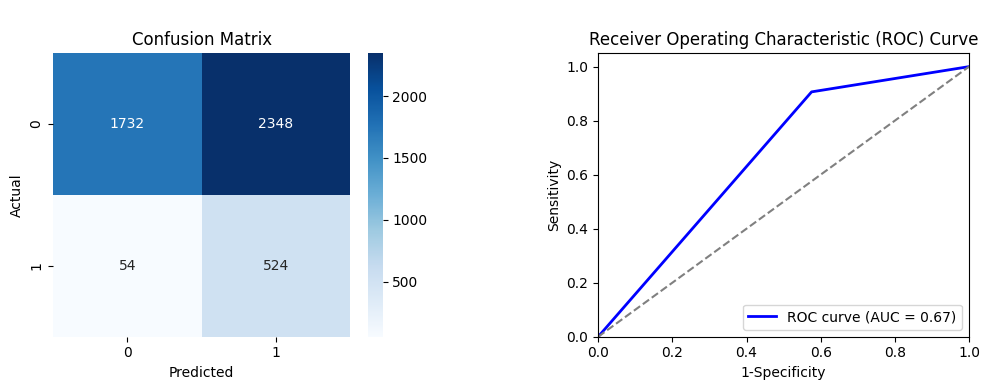

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=2, 
                                  max_depth=10, 
                                  min_samples_split=17, 
                                  min_samples_leaf=5, 
                                  max_features=8, 
                                  criterion='gini',
                                 class_weight = {0:1, 1:2})
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
cm2 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_rf)

In [87]:
calculate_metrics_from_confusion_matrix(cm2)

,Metric,Score
0,Accuracy,0.484328
1,Precision,0.182451
2,Recall,0.906574
3,F1-score,0.303768


### $\textbf{XGboost}$

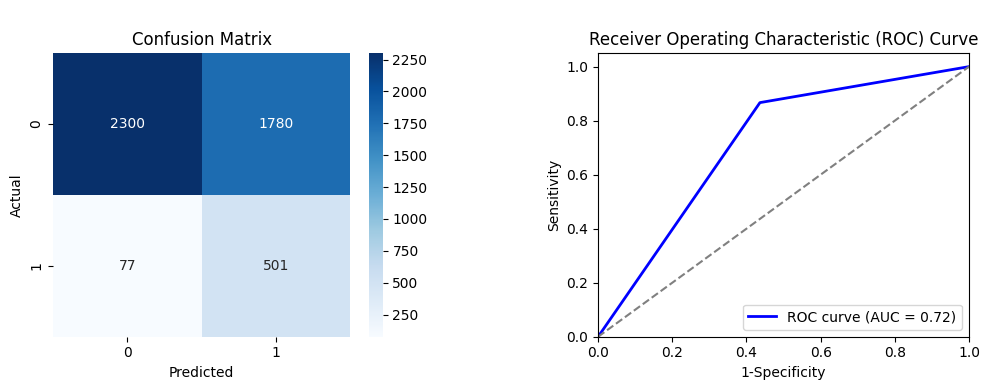

In [88]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=2,
    scale_pos_weight=2,
    min_child_weight=5,
    reg_alpha=1, 
    reg_lambda=0.1
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
cm3 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_xgb)

In [89]:
calculate_metrics_from_confusion_matrix(cm3)

,Metric,Score
0,Accuracy,0.601331
1,Precision,0.219641
2,Recall,0.866782
3,F1-score,0.350472
